## Import libraries

In [62]:
#manipulate paths
import os 

#Cv library
import cv2 as cv

#Plot utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

#Numpy
import numpy as np

#Keras for modelling
import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense
from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

In [63]:
base_path = '/Users/raffaeleanselmo/Desktop/Università/Digital Signal and Image Processing/project/images/'

In [65]:
# Caricamento modello per il rilevamento di volti frontali
face_detector = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

## Preprocessing

In [66]:
batch_size = 32

In [67]:
#Training Set data Augmentation
data_processing = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                     horizontal_flip=True,         #horizontal flip
                                     width_shift_range=0.2,        #width shifting
                                     height_shift_range=0.2,       #height shifting
                                     brightness_range = (0.4,1.5), #brightness shifting
                                     zoom_range = [0.5,1.0],       #Random Zoom
                                     rotation_range=90
                                     )
train_generator = data_processing.flow_from_directory(
        directory=base_path+'TRAINING/',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
        seed=1)

Found 1500 images belonging to 3 classes.


In [68]:
#Test Set data generation
test_processing = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_processing.flow_from_directory(
        directory=base_path+'TEST',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True
)

Found 150 images belonging to 3 classes.


## VGG16 Fine Tuning

In [83]:
#Modello di base
base_net = vgg16.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')


In [84]:
#Creazione di un dizionario che mappi i layer ai loro nomi
layer_dict = dict([(layer.name, layer) for layer in base_net.layers])

In [85]:
#Congelamento del modello di base
for layer in base_net.layers:
    layer.trainable = False

In [86]:
#Output del modello di base
x = base_net.output
#fully-connected intermedio + ReLU
x = Dense(128, activation='relu')(x)
#Dropout
x = Dropout(0.3)(x)
#fully-connected output + softmax
pred = Dense(3, activation='softmax')(x)

In [87]:
#Modello specializzato
net = Model(inputs=base_net.input, outputs=pred)

In [88]:
#Compilazione del modello per l'addestramento
net.compile(loss=categorical_crossentropy,
                      optimizer=Adam(),
                      metrics=['accuracy'])

In [89]:
epochs = 10
steps_per_epoch = 10

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [90]:
history = net.fit_generator(train_generator, 
                            epochs=epochs,
                            steps_per_epoch=steps_per_epoch,
                            validation_data=test_generator,
                            callbacks = [early_stopping]
                           )

Epoch 1/10
10/10 [==============================] - 149s 15s/step - loss: 2.2251 - accuracy: 0.5063 - val_loss: 0.9367 - val_accuracy: 0.6267
Epoch 2/10
10/10 [==============================] - 152s 15s/step - loss: 0.8823 - accuracy: 0.7031 - val_loss: 0.4726 - val_accuracy: 0.8000
Epoch 3/10
10/10 [==============================] - 152s 15s/step - loss: 0.3308 - accuracy: 0.8750 - val_loss: 0.1640 - val_accuracy: 0.9467
Epoch 4/10
10/10 [==============================] - 153s 15s/step - loss: 0.1919 - accuracy: 0.9250 - val_loss: 0.2227 - val_accuracy: 0.8667
Epoch 5/10
10/10 [==============================] - 152s 15s/step - loss: 0.1560 - accuracy: 0.9344 - val_loss: 0.0642 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 153s 15s/step - loss: 0.1130 - accuracy: 0.9531 - val_loss: 0.0563 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 152s 15s/step - loss: 0.1506 - accuracy: 0.9531 - val_loss: 0.0702 - val_accuracy: 1.0000
Epoch 

In [91]:
mpl.rcParams['figure.figsize'] = (18, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], 
             color=colors[0],
             label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'accuracy':
      plt.ylim([0.2,1])
    else:
      plt.ylim([0,1])

    plt.legend()

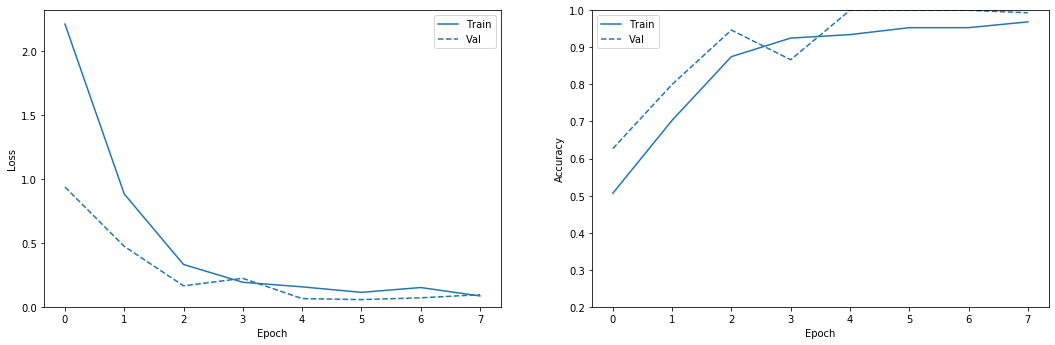

In [92]:
plot_metrics(history)

In [93]:
net.save("FaceRecognition.h5")

## Test statico

In [94]:
names = ['Lorenzo' ,'Raffaele', 'Riprova']

In [103]:
cap = cv.VideoCapture(0)
# Acquisizione immagine
result, img = cap.read()
# Rilascio del dispositivo
cap.release()

In [104]:
faces = face_detector.detectMultiScale(img)
#faces = faces.tolist()

for (x,y,w,h) in faces:
        face = img[y:y+h,x:x+h,:]

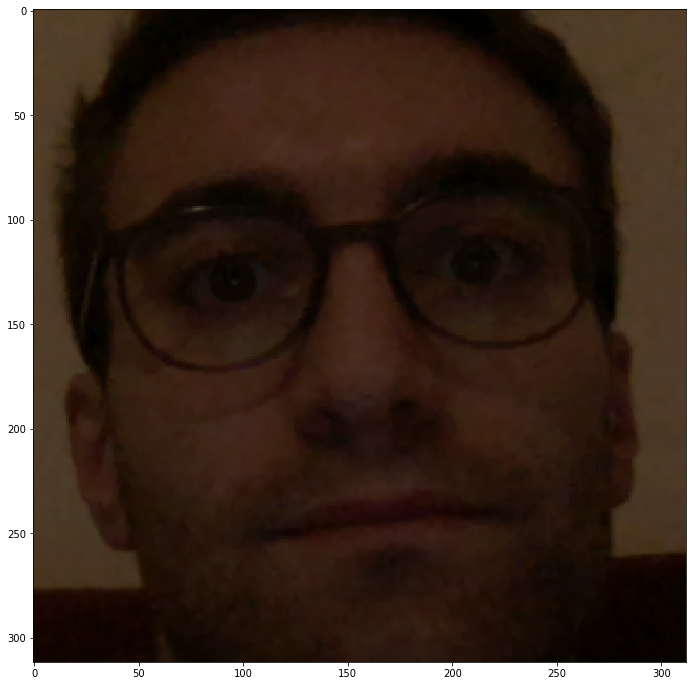

(<matplotlib.image.AxesImage at 0x826a79910>, None)

In [105]:
plt.imshow(face[:,:,-1::-1]), plt.show()

In [106]:
img_pixels = cv.resize(face, (224, 224)) 
img_pixels = img_to_array(img_pixels)
img_pixels = np.expand_dims(img_pixels, axis = 0)
img_pixels = preprocess_input(img_pixels)
y_pred = net.predict(img_pixels)
y_pred= np.argmax(y_pred)
names[y_pred]

'Raffaele'